<a href="https://colab.research.google.com/github/msplittgerber/disaster_response_pipeline_project/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Prediction
Early prediction of sepsis from clinical data, using the [PhysioNet/Computing in Cardiology Challenge 2019 Dataset](https://physionet.org/content/challenge-2019/1.0.0/)

## Setup

In [1]:
from google.colab import drive
import tarfile
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%pip install zstandard
import zstandard
drive.mount('/content/drive')
%mkdir -p "/tmp/sepsis"
%cp "/content/drive/My Drive/sepsis/training.tar.zst" "/tmp/sepsis"
%cp /content/drive/My\ Drive/sepsis/training_setA*.csv "/tmp/sepsis"
%cd "/tmp/sepsis"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.7 MB/s eta 0:00:00
Mounted at /content/drive
/tmp/sepsis


**Read data file**

In [3]:
# EITHER: run this line
# OR: run all cells until "Optional: save as csv"
full_df = pd.read_csv("/tmp/sepsis/training_setA.csv")

In [15]:
dctx = zstandard.ZstdDecompressor()
with open("training.tar.zst", 'rb') as ifh, open("training.tar", 'wb') as ofh:
    dctx.copy_stream(ifh, ofh)

my_tar = tarfile.open('training.tar')
my_tar.extractall('/tmp/sepsis') # specify which folder to extract to
my_tar.close()
%cd "training/training_setA"

/tmp/sepsis/training/training_setA


In [16]:
# load all data sets (roughly 20000 for set A)
wd = Path(".")
full_df_from_disk = list(pd.read_csv(f, sep = "|") for f in wd.glob("p0*.psv"))
full_df = pd.concat(full_df_from_disk)

## Preprocess Data File
Only if data was read in via .psv files

In [4]:
full_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,1,0,0
1,1,52.0,98.0,NaN,134.0,72.67,NaN,20.0,NaN,NaN,...,NaN,266.0,76.16,0,1.0,0.0,-0.02,2,0,0
2,2,NaN,NaN,NaN,143.0,80.33,NaN,NaN,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,3,0,0
3,3,60.0,99.0,36.22,154.0,83.33,NaN,16.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,4,0,0
4,4,51.0,98.0,NaN,155.0,98.33,NaN,20.0,NaN,NaN,...,NaN,NaN,76.16,0,1.0,0.0,-0.02,5,0,0


In [5]:
full_df.columns

Index(['time', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'patient_id'],
      dtype='object')

Reset index, creating time variable

In [6]:
def add_patient_id_and_idx(df):
  # Reset index, creating time variable
  df = df.reset_index(names=["time"])
  # Add patient id variable
  groups_by_patient = df['time'].diff().lt(0)
  groups_by_sepsis_label = df['SepsisLabel'].diff().abs().gt(0)
  result = pd.concat([groups_by_patient, groups_by_sepsis_label], axis=1)
  groups = result.any(axis=1)
  df['patient_id'] = groups_by_patient.cumsum()
  df['measurement_id'] = groups.cumsum()

  return df

In [28]:
full_df = add_patient_id_and_idx(full_df)

In [29]:
display(full_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.72,98.0,75.00,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,NaN,94.0,79.00,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,NaN,78.5,67.00,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,NaN,88.0,73.00,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.50,83.0,69.00,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,36,96.0,99.0,NaN,NaN,NaN,NaN,22.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,37,0,20335,21922
790211,37,94.5,99.5,36.56,90.0,63.33,NaN,22.0,NaN,6.0,...,129.0,72.53,1,NaN,NaN,-26.63,38,0,20335,21922
790212,38,100.0,100.0,NaN,98.0,66.17,NaN,22.5,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,39,0,20335,21922
790213,39,98.0,100.0,NaN,91.0,63.67,NaN,29.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,40,0,20335,21922


Optional: save as csv

In [30]:
full_df.to_csv("/tmp/sepsis/training_setA.csv", index=False)

## Exploratory Data Analysis

### Single and Subsample Analysis

Single case

In [31]:
first_patient_df = pd.read_csv("p000010.psv", sep="|")

<Axes: >

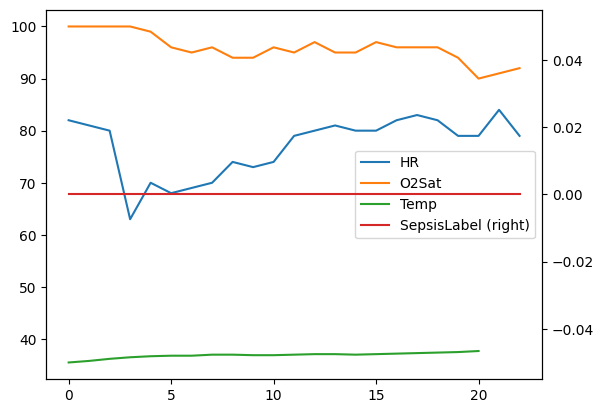

In [32]:
ax = first_patient_df[["HR", "O2Sat", "Temp"]].plot()
first_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

In [33]:
first_patient_df.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

<Axes: >

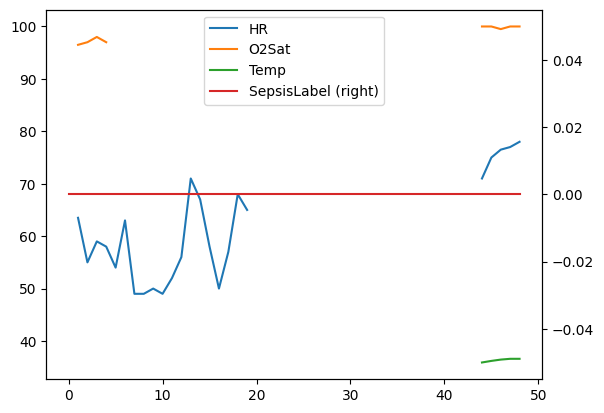

In [34]:
second_patient_df = pd.read_csv("p000111.psv", sep="|")
ax = second_patient_df[["HR", "O2Sat", "Temp"]].plot()
second_patient_df[["SepsisLabel"]].plot(secondary_y=True, ax=ax)

Subsample (first n samples)

In [35]:
# load the first 10 data sets
wd = Path(".")
sample_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p00000*.psv"))
sample_df = pd.concat(sample_df)

<Axes: >

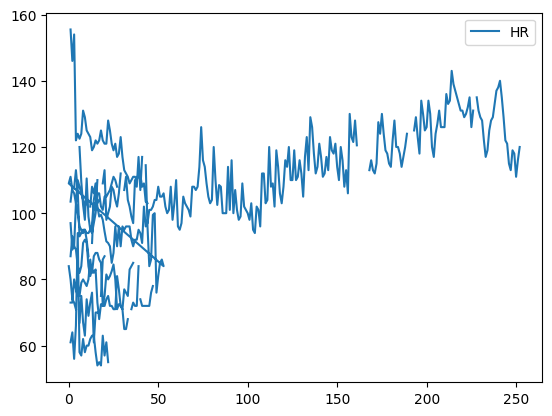

In [36]:
sample_df[["HR"]].plot()

39.6956956956957 mean total hours time in the ICU


Text(0.5, 0, 'ICULOS (days)')

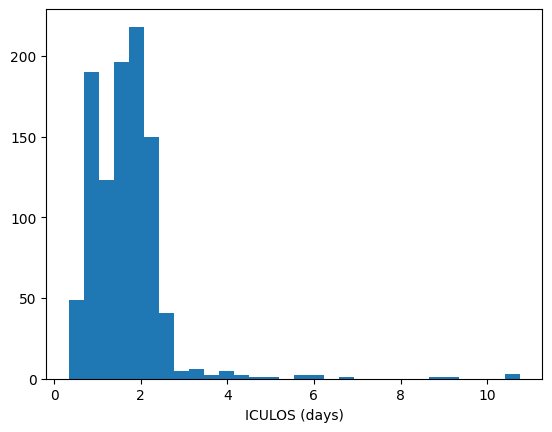

In [37]:
# load the first 1000 data sets
# what is the mean total time in the ICU (ICULOS)?
# ICULOS = intensive care unit length of stay
wd = Path(".")
big_df = (pd.read_csv(f, sep = "|") for f in wd.glob("p000*.psv"))
ICULOS_times = np.array([])
for df in big_df:
  ICULOS_times = np.append(ICULOS_times, df[["ICULOS"]].max())
print(f"{np.mean(ICULOS_times)} mean total hours time in the ICU")
plt.hist(ICULOS_times/24, bins=30)
plt.xlabel('ICULOS (days)')

### Full Sample Analysis

Number of patiens in total and patients with sepsis

In [38]:
print("Number of patients:", len(full_df['patient_id'].unique()))

grp_sepsis_rep = np.array(full_df.groupby(['patient_id']) \
                          ['SepsisLabel'].sum())

print("Number of patients with sepsis:", len(grp_sepsis_rep[grp_sepsis_rep > 0]))


print("Percentage of positive cases:", round(len(grp_sepsis_rep[grp_sepsis_rep > 0])/len(full_df['patient_id'].unique())*100, 2), "%")



Number of patients: 20336
Number of patients with sepsis: 1790
Percentage of positive cases: 8.8 %


Number of hours a patient spent in hospital

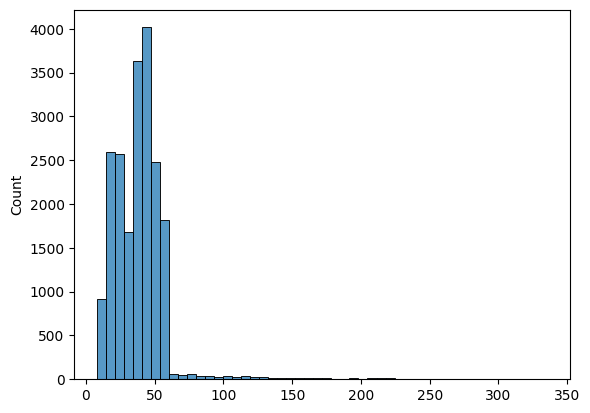

In [39]:
agg_patient_time = np.array(full_df.groupby(['patient_id'])['SepsisLabel']\
                            .count())

sns.histplot(agg_patient_time, kde=False, bins = 50);

Time at which a patient contracts Sepsis

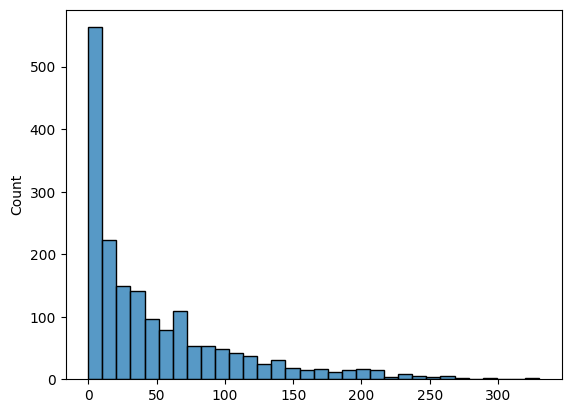

In [40]:

temp = full_df.groupby(['patient_id'])['SepsisLabel']\
       .sum().reset_index()

sepsis_pid = np.array(temp[temp['SepsisLabel'] > 0]['patient_id'])


temp_filter = full_df[full_df['patient_id']\
                                   .isin(sepsis_pid)]

sepsis_time = []
tot_time = []


for pid in sepsis_pid:
  df = temp_filter[temp_filter['patient_id']==pid]
  sepsis_time.append(df[df['SepsisLabel']==1]['time'].iloc[0])
  tot_time.append(df[df['SepsisLabel']==1]['time'][::-1].iloc[0])

sns.histplot(sepsis_time, kde=False);


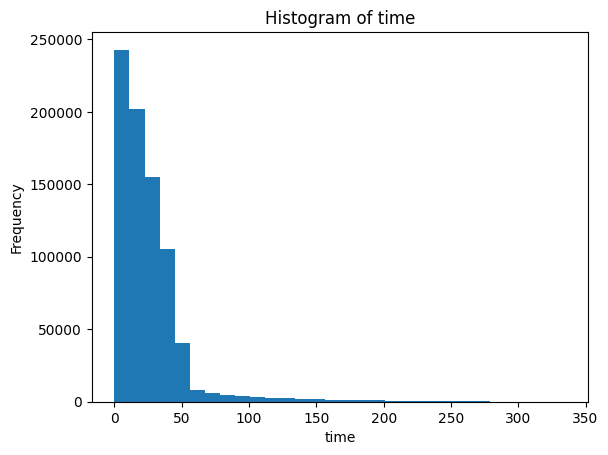

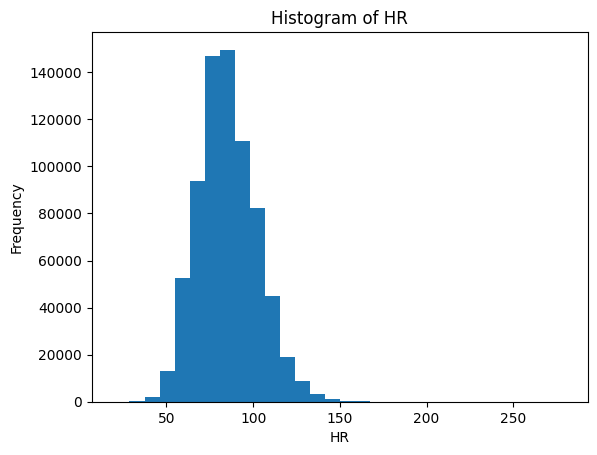

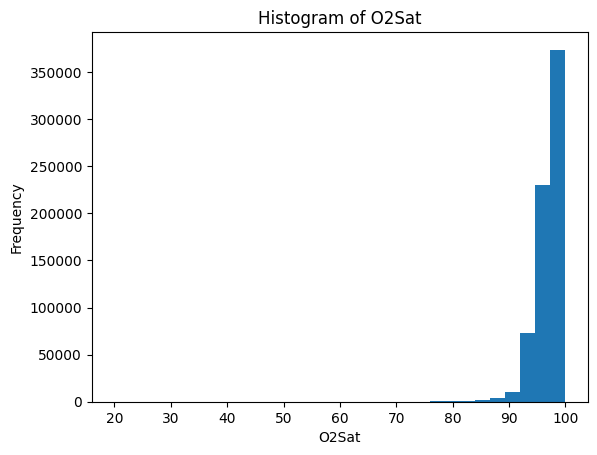

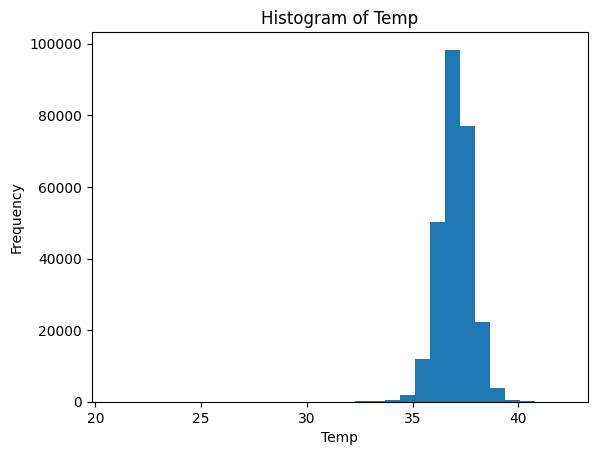

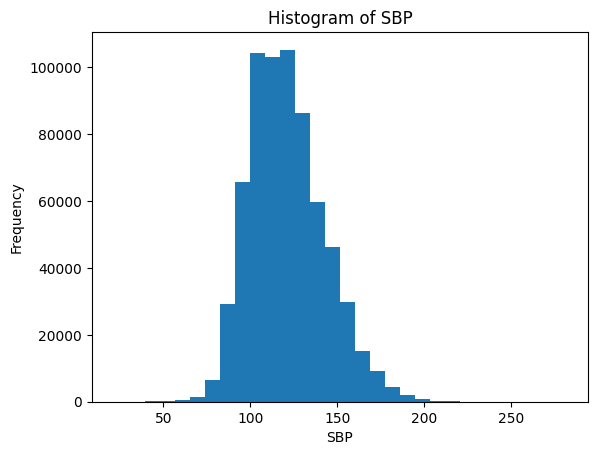

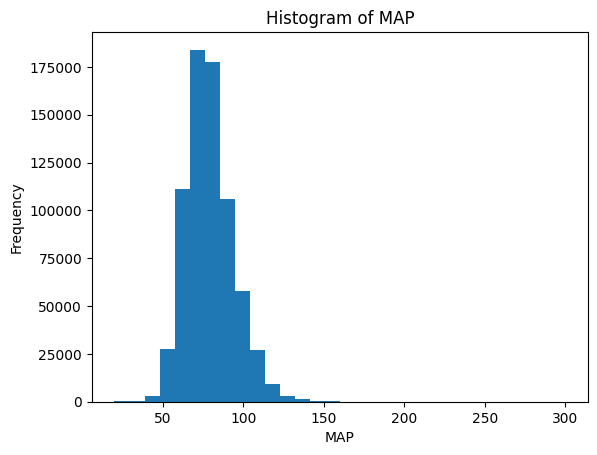

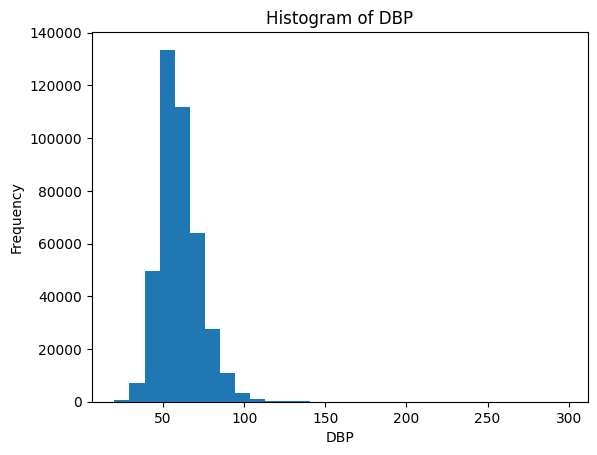

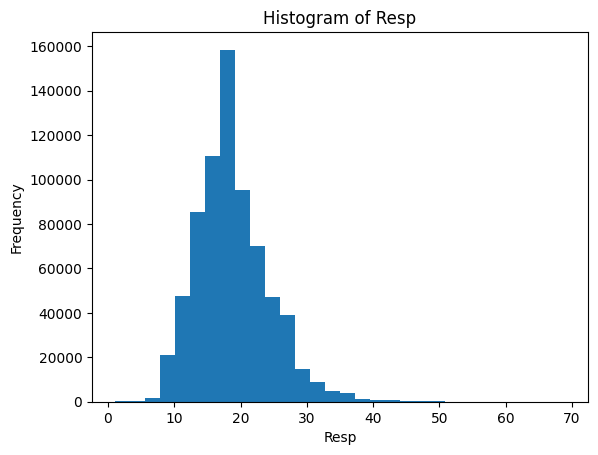

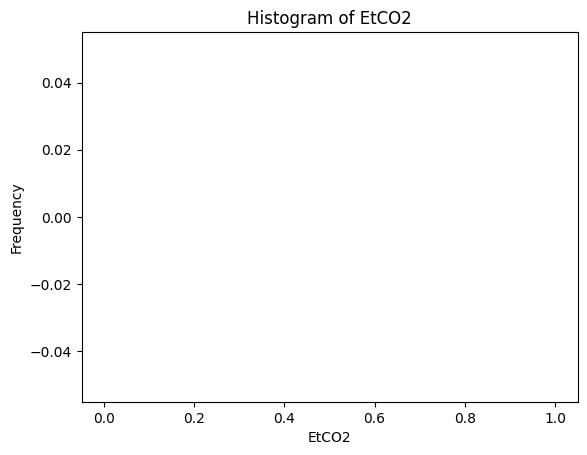

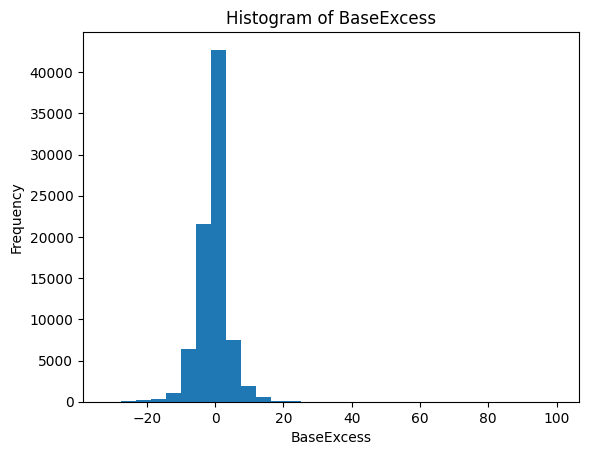

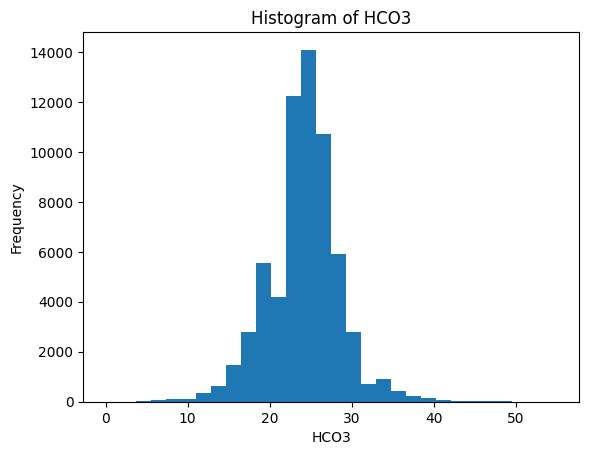

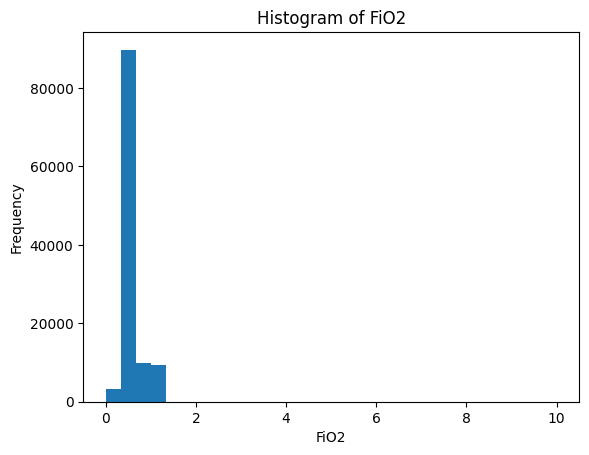

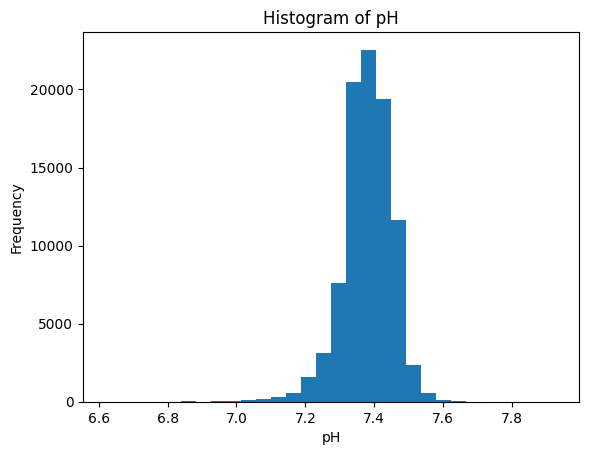

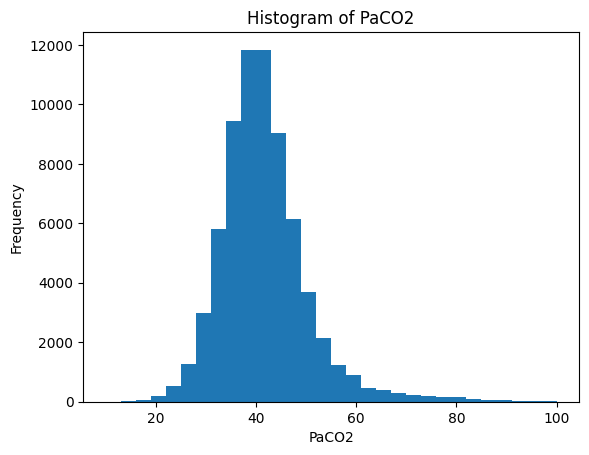

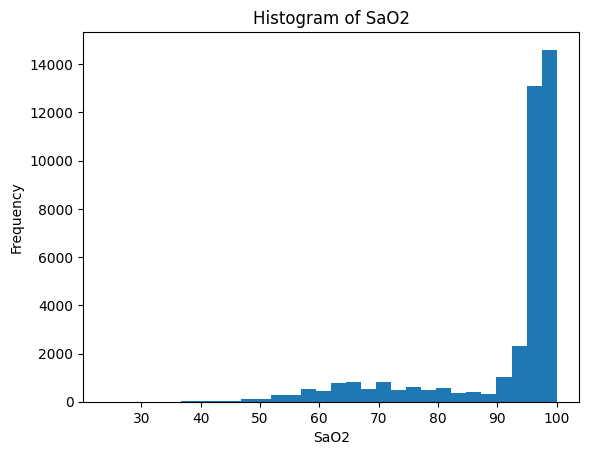

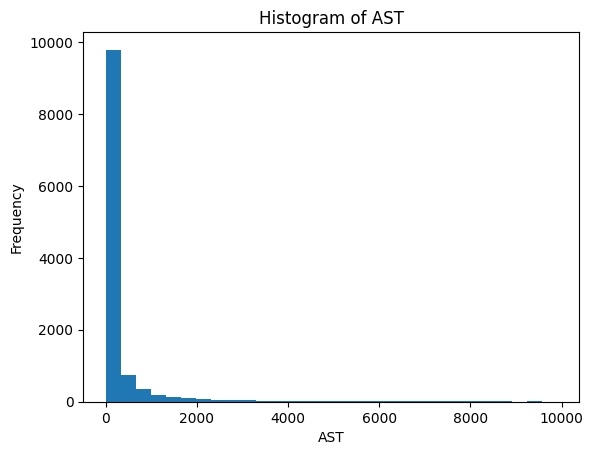

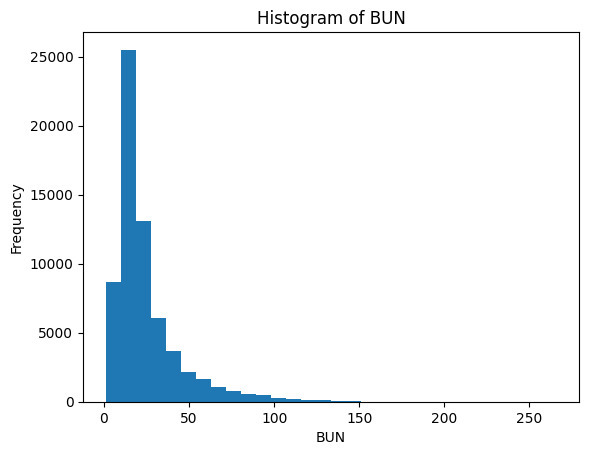

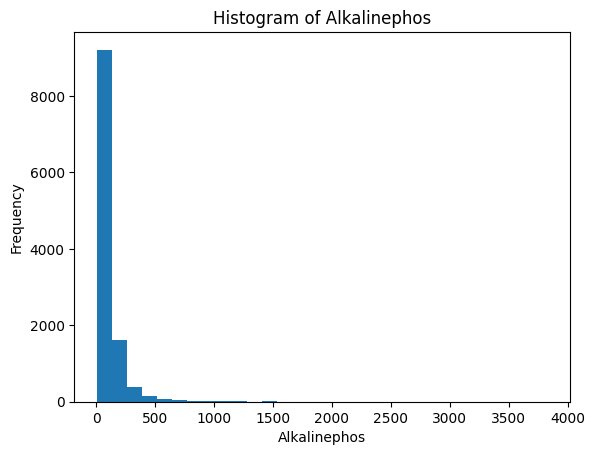

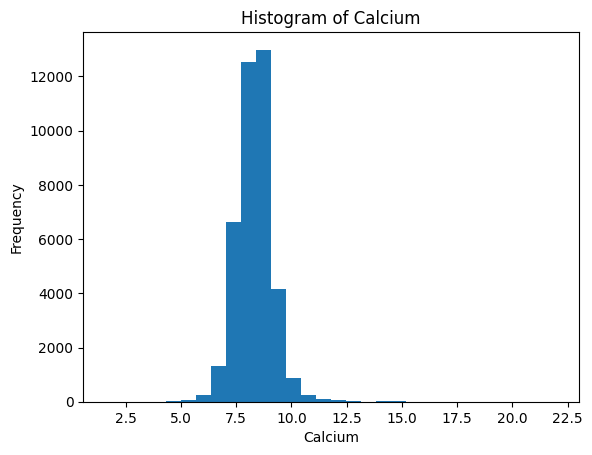

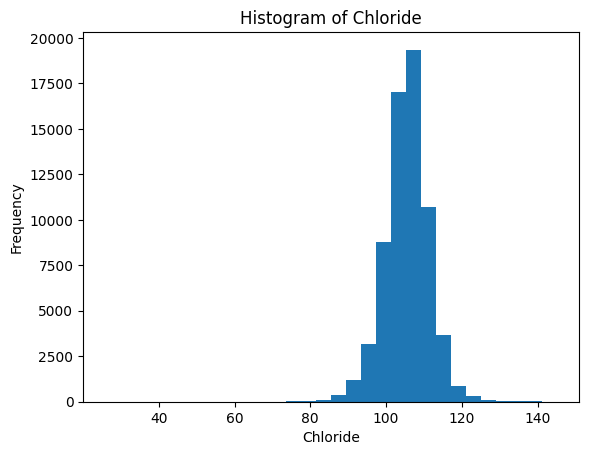

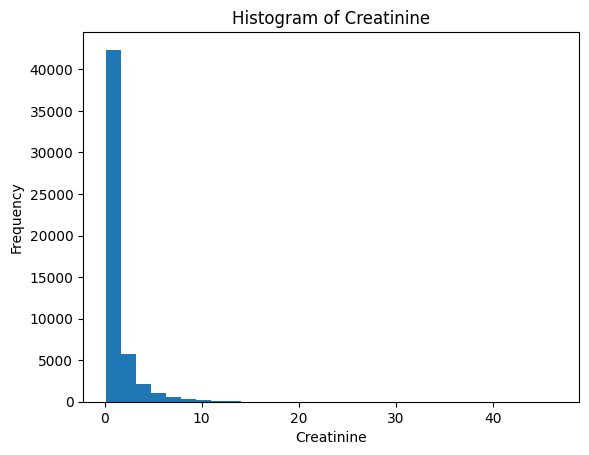

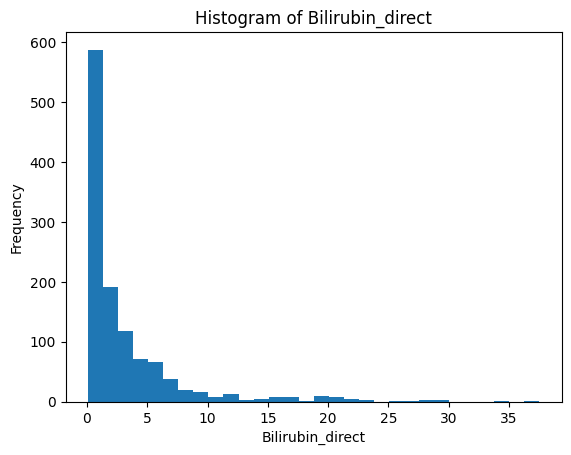

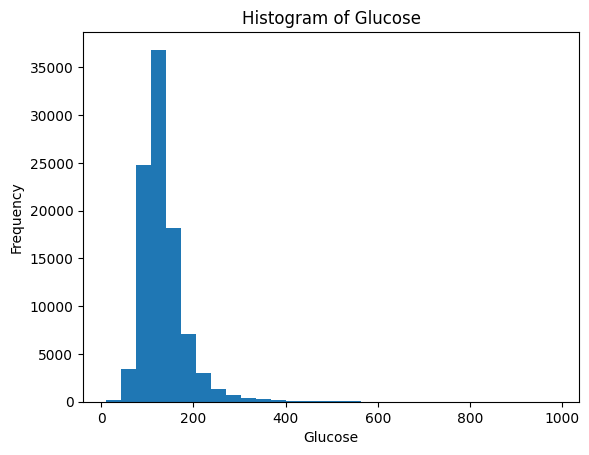

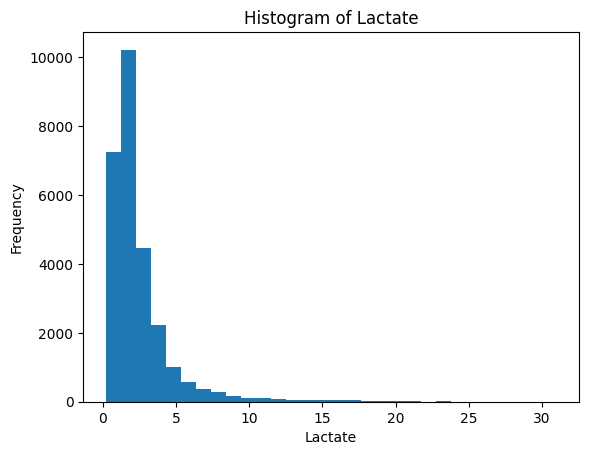

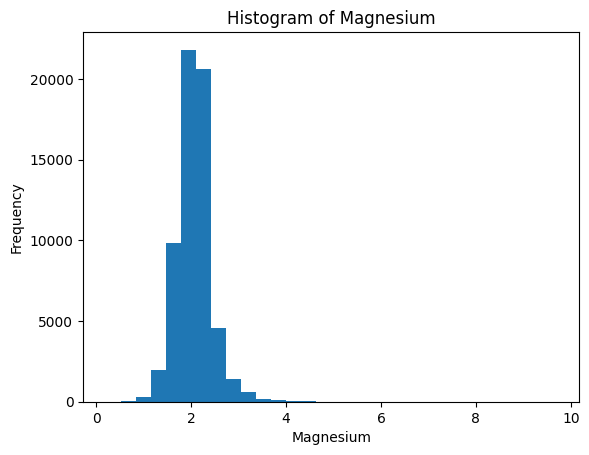

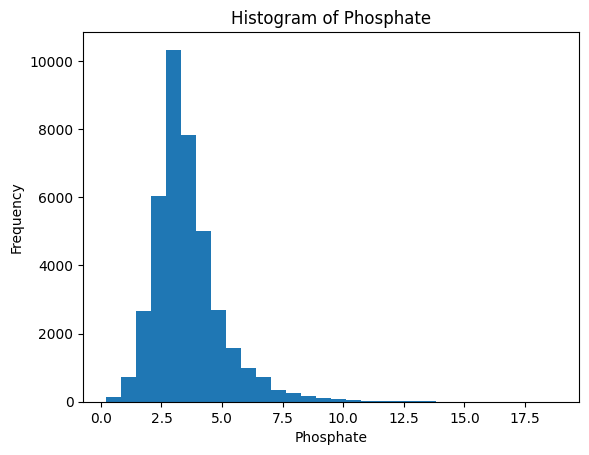

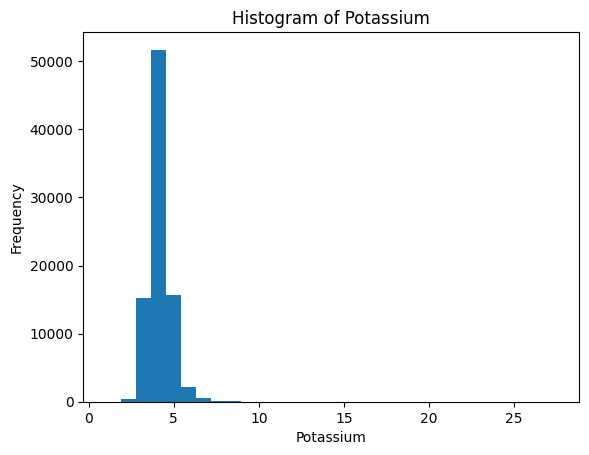

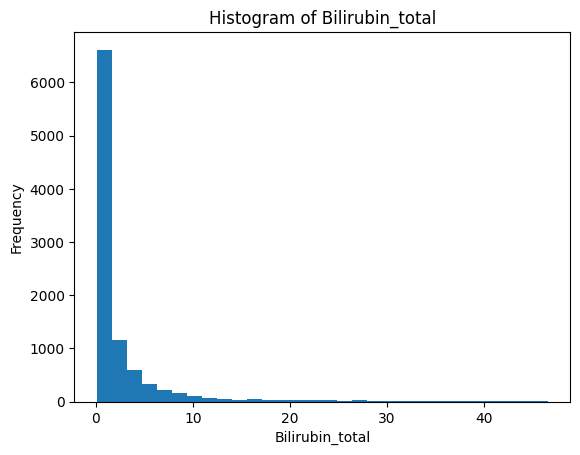

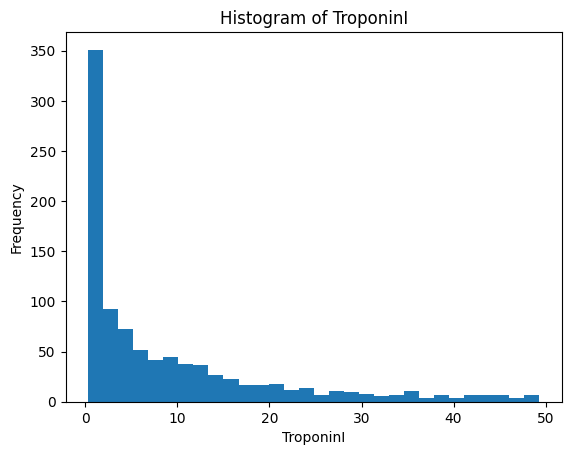

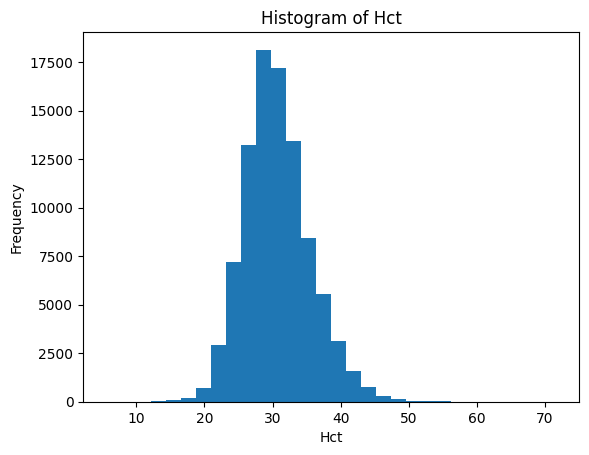

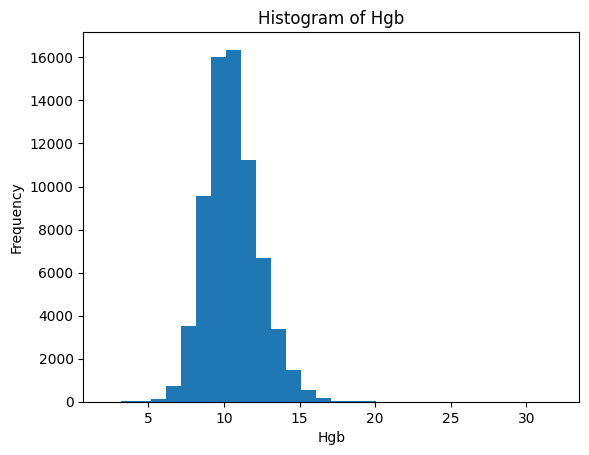

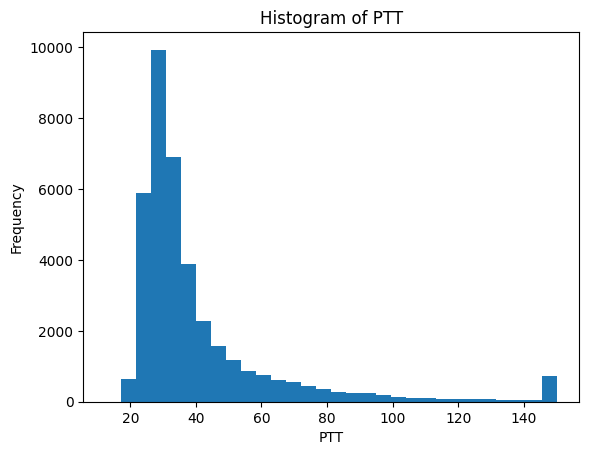

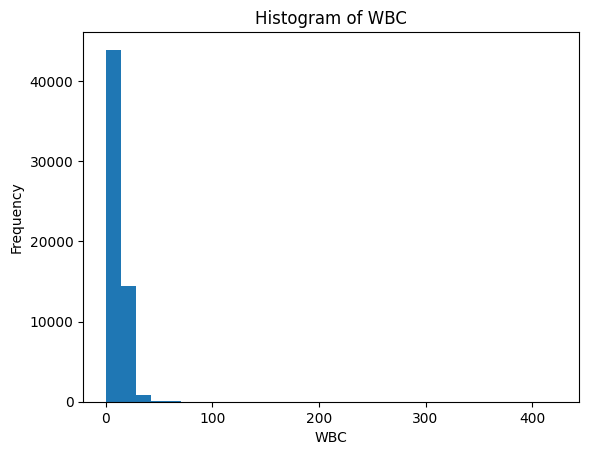

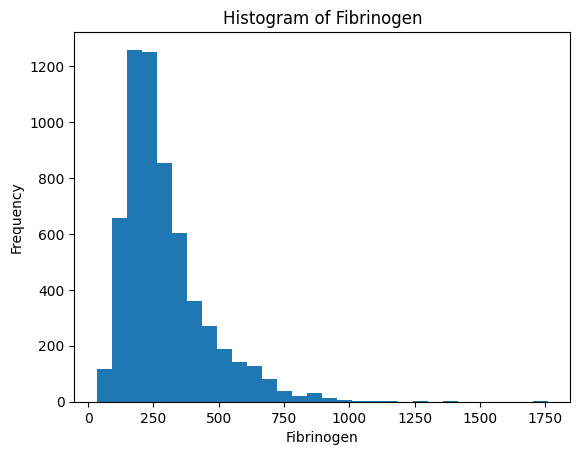

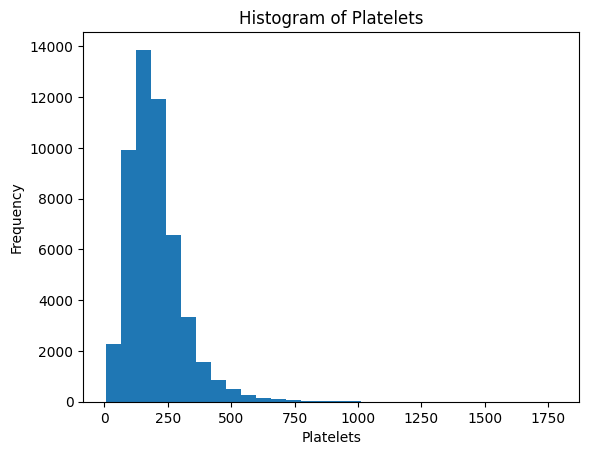

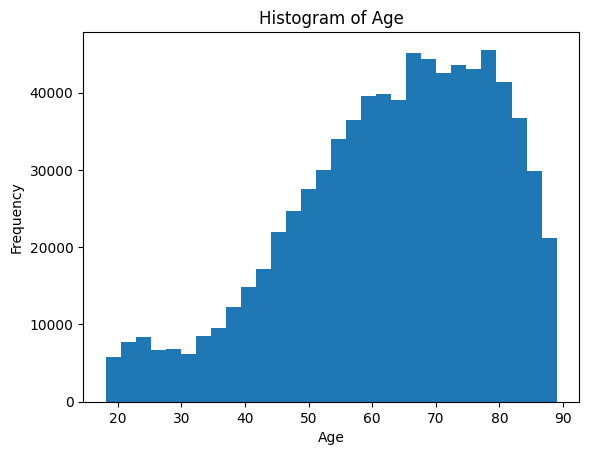

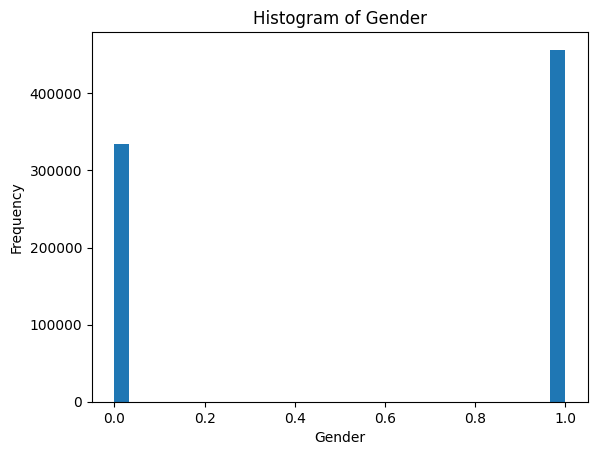

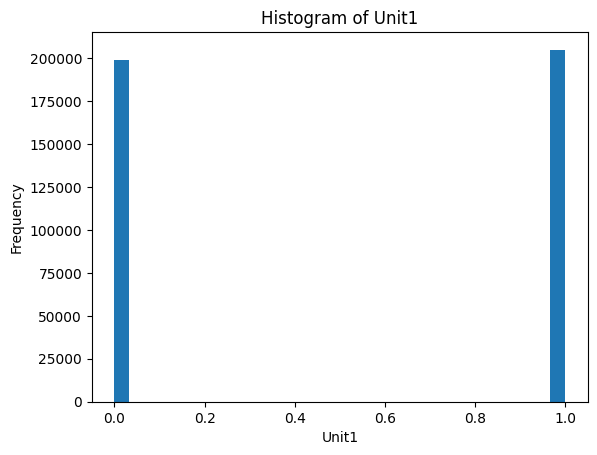

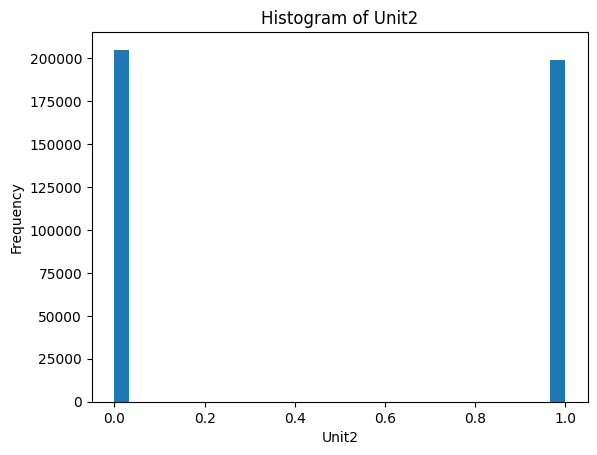

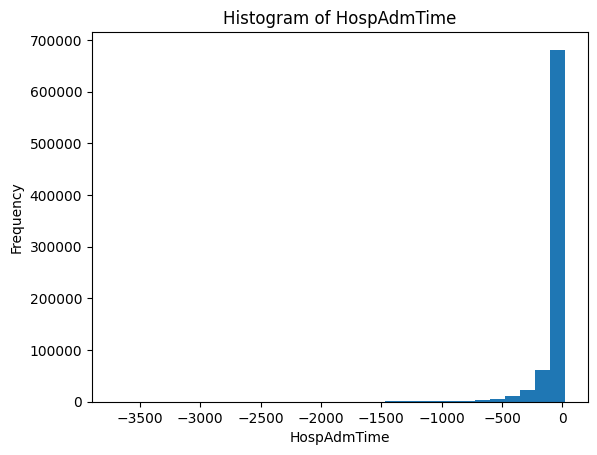

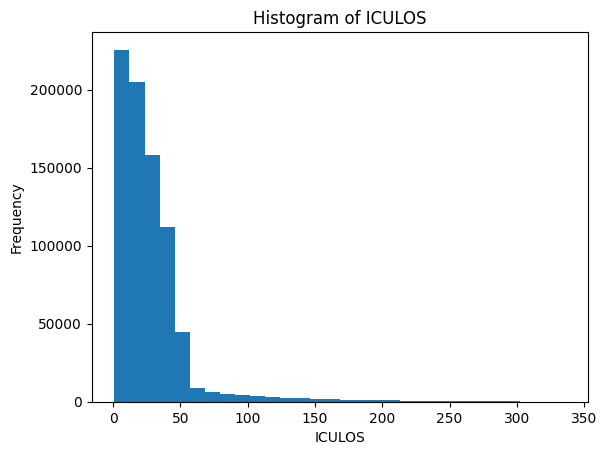

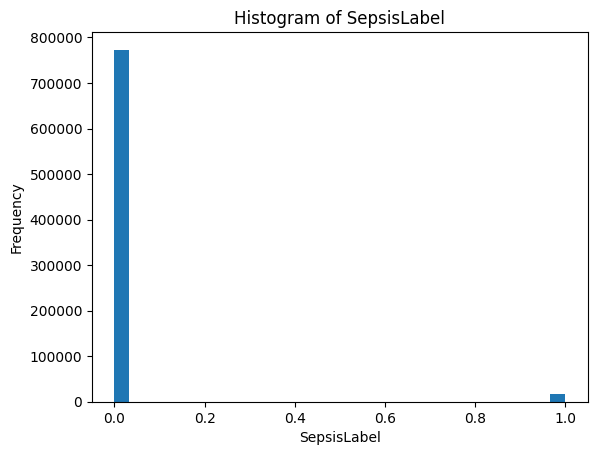

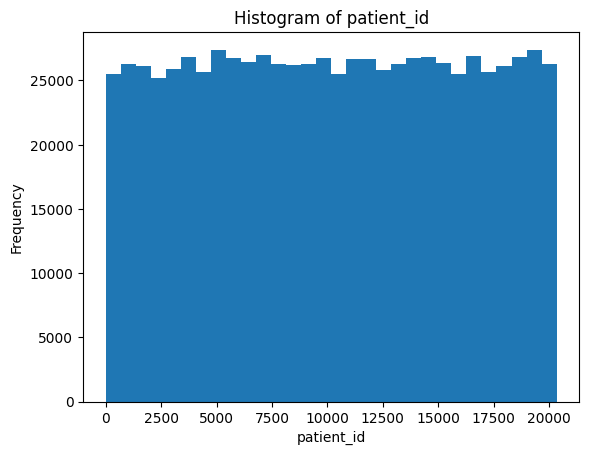

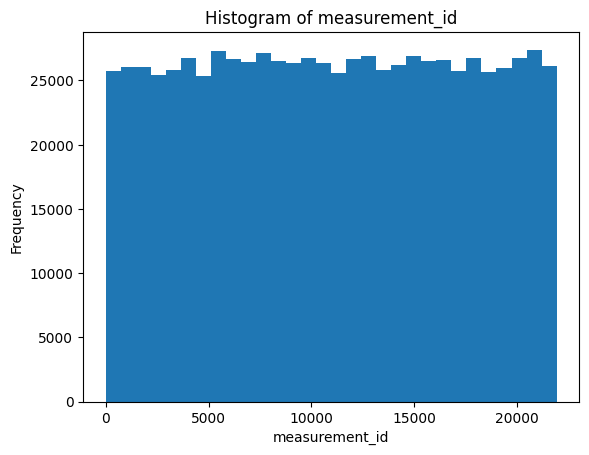

In [41]:
for column in full_df.columns:
    # Generate histogram for the current column
    plt.figure()  # Create a new figure for each column
    full_df[column].plot(kind='hist', bins=30)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()  # Display the histogram

In [ ]:
#sns.pairplot(full_df)

## Initial Interpolation

In [42]:
# interpolate full df
interpolation_limits = [1, 3, 5]

full_df_interpolated = [pd.concat([d.interpolate(limit=lim) for d in full_df_from_disk]) for lim in interpolation_limits]

In [43]:
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit1               0.511317
Unit2               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

We see that the columns `Age, ICULOS, HospAdmTime, Gender` and `SepsisLabel` are thankfully complete. No need to interpolate those, dropping those for further analysis. `EtCO2` is dropped for missing data entirely. One can also discuss dropping measurements with less than 5% overall data at this point.

EtCO2               0.000000
TroponinI           0.001221
Bilirubin_direct    0.001496
Fibrinogen          0.007631
Bilirubin_total     0.012266
Alkalinephos        0.014593
AST                 0.014958
Lactate             0.034349
PTT                 0.048475
SaO2                0.049556
Calcium             0.049756
Phosphate           0.050488
Platelets           0.065171
Creatinine          0.066421
WBC                 0.075104
Magnesium           0.077803
HCO3                0.080506
BUN                 0.081593
Chloride            0.083239
PaCO2               0.087682
Hgb                 0.088357
BaseExcess          0.104251
Potassium           0.108624
pH                  0.114671
Hct                 0.117763
Glucose             0.122316
FiO2                0.141930
Temp                0.337757
Unit1               0.511317
Unit2               0.511317
DBP                 0.518742
SBP                 0.847888
O2Sat               0.879680
MAP                 0.897676
Resp          

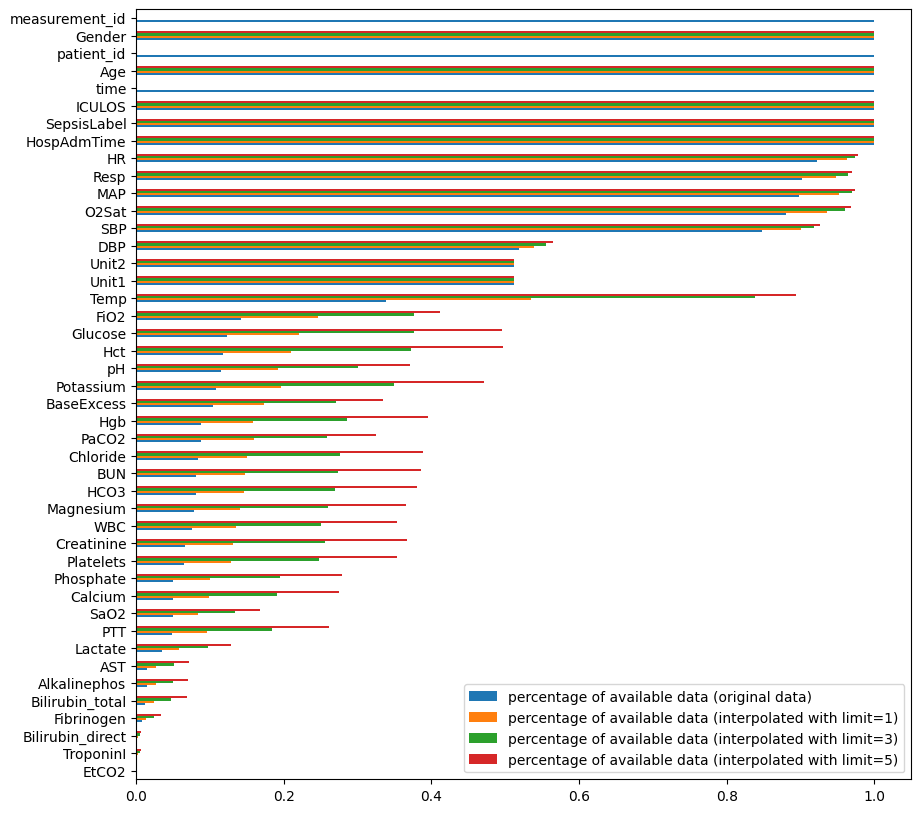

In [44]:
#dropped_cols = ["Age", "ICULOS", "HospAdmTime", "Gender", "SepsisLabel", "EtCO2"]

#full_df = full_df.drop(columns=dropped_cols)
#full_df_interpolated = [d.drop(columns=dropped_cols) for d in full_df_interpolated]

# recalculate with the smaller data frame.
value_availability = full_df.count().sort_values()/full_df.shape[0]
display(value_availability)

fig, ax = plt.subplots()

value_availability_interpolated = [
    d.count().sort_values()/full_df.shape[0] for d in full_df_interpolated
]

res = pd.concat([value_availability, *value_availability_interpolated],axis=1)

res.plot.barh(figsize=(10,10), ax=ax)
ax.legend(["percentage of available data (original data)",
           *[f"percentage of available data (interpolated with limit={lim})" for lim in interpolation_limits]])

In [45]:
full_df_interpolated = [add_patient_id_and_idx(d) for d in full_df_interpolated]
for limit, df in zip(interpolation_limits, full_df_interpolated):
  df.to_csv(f"/tmp/sepsis/training_setA_interpolated_{limit}.csv", index=False)

## Analyse Feature Contribution

### Using KNNs

In [48]:
ref_df =full_df_interpolated[2]
display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.000000,75.000000,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.000000,79.000000,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.500000,67.000000,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.000000,73.000000,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.000000,69.000000,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,36,96.0,99.0,NaN,93.333333,65.553333,NaN,22.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,37,0,20335,21922
790211,37,94.5,99.5,36.560,90.000000,63.330000,NaN,22.0,NaN,6.000000,...,129.0,72.53,1,NaN,NaN,-26.63,38,0,20335,21922
790212,38,100.0,100.0,36.560,98.000000,66.170000,NaN,22.5,NaN,4.333333,...,129.0,72.53,1,NaN,NaN,-26.63,39,0,20335,21922
790213,39,98.0,100.0,36.560,91.000000,63.670000,NaN,29.0,NaN,2.666667,...,129.0,72.53,1,NaN,NaN,-26.63,40,0,20335,21922


In [65]:
ref_df = pd.read_csv("/tmp/sepsis/training_setA_interpolated_3.csv")

display(ref_df)

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.000000,75.000000,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.000000,79.000000,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.500000,67.000000,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.000000,73.000000,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.000000,69.000000,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790210,36,96.0,99.0,NaN,93.333333,65.553333,NaN,22.0,NaN,NaN,...,NaN,72.53,1,NaN,NaN,-26.63,37,0,20335,21922
790211,37,94.5,99.5,36.560,90.000000,63.330000,NaN,22.0,NaN,6.000000,...,129.0,72.53,1,NaN,NaN,-26.63,38,0,20335,21922
790212,38,100.0,100.0,36.560,98.000000,66.170000,NaN,22.5,NaN,4.333333,...,129.0,72.53,1,NaN,NaN,-26.63,39,0,20335,21922
790213,39,98.0,100.0,36.560,91.000000,63.670000,NaN,29.0,NaN,2.666667,...,129.0,72.53,1,NaN,NaN,-26.63,40,0,20335,21922


In [50]:
print("std dev:")
display(ref_df.std().sort_values(ascending=False))

ref_availability = ref_df.count().sort_values(ascending=False)/ref_df.shape[0]

print("availability")
display(ref_availability)

std dev:


measurement_id      6317.035041
patient_id          5863.606214
AST                 1020.777944
Fibrinogen           158.915784
HospAdmTime          155.864937
Alkalinephos         146.593382
Platelets            108.562406
Glucose               46.993397
ICULOS                28.190940
time                  27.954160
PTT                   22.169718
SBP                   21.466224
BUN                   20.279263
HR                    16.942832
Age                   16.133632
MAP                   14.997445
DBP                   12.763712
SaO2                  11.971514
TroponinI             11.281380
PaCO2                  8.526780
WBC                    7.222523
Chloride               5.806818
Resp                   5.362928
Bilirubin_total        5.214619
Hct                    4.689102
Bilirubin_direct       4.571821
HCO3                   4.323812
BaseExcess             4.139719
O2Sat                  3.012240
Lactate                2.119999
Hgb                    1.692575
Creatini

availability


time                1.000000
Age                 1.000000
patient_id          1.000000
SepsisLabel         1.000000
ICULOS              1.000000
Gender              1.000000
measurement_id      1.000000
HospAdmTime         0.999990
HR                  0.974035
MAP                 0.969422
Resp                0.964281
O2Sat               0.960406
SBP                 0.918580
Temp                0.838959
DBP                 0.554711
Unit2               0.511317
Unit1               0.511317
Glucose             0.376229
FiO2                0.375932
Hct                 0.372580
Potassium           0.349089
pH                  0.300366
Hgb                 0.285478
Chloride            0.276158
BUN                 0.273393
BaseExcess          0.270038
HCO3                0.269473
Magnesium           0.260081
PaCO2               0.259050
Creatinine          0.255498
WBC                 0.250005
Platelets           0.247386
Phosphate           0.194143
Calcium             0.191309
PTT           

In [52]:
play_df = pd.DataFrame({"sepsis_label": [0,0,1,1,0,0,1,0,1,0], "measurement_id": [0,0,0,0,0,0,1,1,1,2]} )
display(play_df)

,sepsis_label,measurement_id
0,0,0
1,0,0
2,1,0
3,1,0
4,0,0
5,0,0
6,1,1
7,0,1
8,1,1
9,0,2


In [53]:
import math
def classify_pairs(df):
  """Take pairs of time series values and assign a sepsis_class as follows:
  00: A
  01: B
  10: C
  11: D

  Ensures that no comparisons are done between patients.
  """
  sepsis_label_df = df.diff()["SepsisLabel"].replace({1: "B", -1: "C"})
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 0)["SepsisLabel"])] = "A"
  sepsis_label_df[(sepsis_label_df == 0) & ((df == 1)["SepsisLabel"])] = "D"
  sepsis_label_df[df.diff()["patient_id"] != 0] = math.nan

  _df = df.copy()
  _df["SepsisClass"] = sepsis_label_df
  return _df

In [64]:
print("distribution of transitions: A remains non-septic, B becomes septic, D remains septic")
sepsis_class_df = classify_pairs(ref_df)
display(sepsis_class_df["SepsisClass"].value_counts())
print("sanity check: overall (non-)septic timestamps")
display(ref_df["SepsisLabel"].value_counts())

distribution of transitions: A remains non-septic, B becomes septic, D remains septic


KeyError: ignored

In [55]:
import xgboost as xgb

# try random forest as outlined here: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# one hot encoding is skipped (we only have binary or continous data, nothing categorical)
# we also don't have temporal variables

# we can try the following data sets:
# original data (classified as sepsis/non-sepsis)
# original data (classified as transitions)
# pairs of data (classified as transitions)

# todo: should data be normalized, like pixels (to [0, 1]?)
labels = np.array(ref_df['SepsisLabel'])
ref_df = ref_df.drop('SepsisLabel', axis = 1)
ref_df_names = list(ref_df.columns)
ref_df_as_array = np.array(ref_df)


# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(ref_df_as_array, labels, test_size = 0.25, random_state = 42)

### sklearn trees (hist gradient boosting)

In [56]:
# Import the model we are using
# Random Forest does not work due to NaN values.
# HistGradientBoostingClassifier is suggested as alternative but that one does
#  not give importances.
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingClassifier # Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42) # Train the model on training data
rf = HistGradientBoostingClassifier(verbose=1, max_depth=12, max_iter=100, random_state = 42)
est = rf.fit(train_features, train_labels);

Binning 0.183 GB of training data: 1.184 s
Binning 0.020 GB of validation data: 0.062 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.09888, val loss: 0.09924, in 0.116s
[2/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.09623, val loss: 0.09675, in 0.136s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.09433, val loss: 0.09494, in 0.134s
[4/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.09286, val loss: 0.09363, in 0.140s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.09162, val loss: 0.09257, in 0.157s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.09060, val loss: 0.09163, in 0.152s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.08967, val loss: 0.09085, in 0.146s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.08888, val loss: 0.09021, in 0.168s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.08817, val loss: 0.08949, in 0.142s
[10/100] 1 tree, 31 leaves, max depth = 10, tr

In [57]:
# use a confusion matrix here to get a better idea of how good we are:
# https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

print(f"test data accuracy: {est.score(train_features, train_labels)}")
print(f"validation data accuracy: {est.score(test_features, test_labels)}")

test data accuracy: 0.9793946286325572
validation data accuracy: 0.9785678852364417


In [58]:
# runtime:
# model iterations | time
# 10               | 2:26
# 20               | 4:08
# 30               | 6 min (?)
# 40               | 7:54
# 100              | 17:19
# 700              | 1:51:34
# As this has complexity in O(n^2), where n is the number of model parameters
# (roughly 50 in our case), we expect this value to decrease a lot after parameter
# elimination


# see here: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html
from sklearn.inspection import permutation_importance


train_result = permutation_importance(
    rf, train_features, train_labels, n_repeats=3, random_state=42, n_jobs=-1
)
test_results = permutation_importance(
    rf, test_features, test_labels, n_repeats=3, random_state=42, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=ref_df.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

KeyboardInterrupt: ignored

In [ ]:
# this cell takes a LOT of time.

from sklearn.model_selection import LearningCurveDisplay
LearningCurveDisplay.from_estimator(est, train_features, train_labels, n_jobs=-1)

NameError: ignored

### XGBoost

In [59]:
# prepare

# prepare data for use with XGBoost.
# from https://www.datacamp.com/tutorial/xgboost-in-python
dtrain_clf = xgb.DMatrix(train_features, train_labels, feature_names=ref_df_names, enable_categorical=True)
dtest_clf = xgb.DMatrix(test_features, test_labels, feature_names=ref_df_names, enable_categorical=True)

# train
# to convert the SepsisClass (which is not used yet) you have to use a numerical
# representation, where the following snippet might come in handy:
# Encode y to numeric
# y_encoded = OrdinalEncoder().fit_transform(y)

params = {"objective": "binary:logistic", "tree_method": "gpu_hist"}

n = 1000
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50 # Activate early stopping
)

# evaluate
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_clf)

[0]	train-logloss:0.45779	validation-logloss:0.45806
[10]	train-logloss:0.09073	validation-logloss:0.09274
[20]	train-logloss:0.07856	validation-logloss:0.08279
[30]	train-logloss:0.07392	validation-logloss:0.07951
[40]	train-logloss:0.07133	validation-logloss:0.07779
[50]	train-logloss:0.06785	validation-logloss:0.07535
[60]	train-logloss:0.06500	validation-logloss:0.07310
[70]	train-logloss:0.06310	validation-logloss:0.07161
[80]	train-logloss:0.06080	validation-logloss:0.06994
[90]	train-logloss:0.05841	validation-logloss:0.06829
[100]	train-logloss:0.05574	validation-logloss:0.06638
[110]	train-logloss:0.05397	validation-logloss:0.06501
[120]	train-logloss:0.05213	validation-logloss:0.06364
[130]	train-logloss:0.05098	validation-logloss:0.06286
[140]	train-logloss:0.04966	validation-logloss:0.06180
[150]	train-logloss:0.04857	validation-logloss:0.06106
[160]	train-logloss:0.04714	validation-logloss:0.05992
[170]	train-logloss:0.04594	validation-logloss:0.05911
[180]	train-logloss:0

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

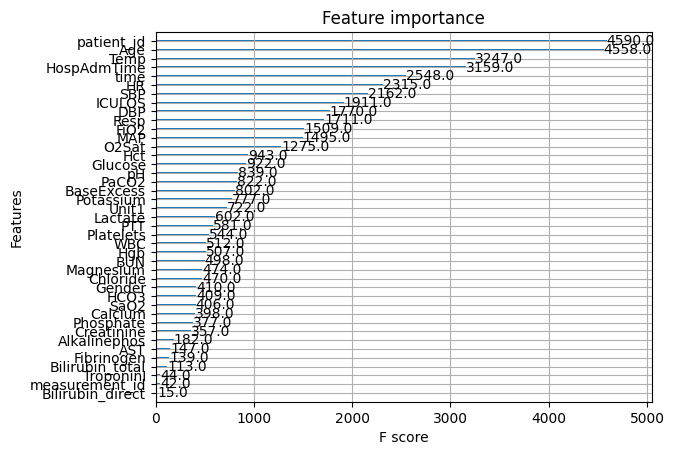

In [60]:
from xgboost import plot_importance
plot_importance(model)

In [66]:
ref_df.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,patient_id,measurement_id
0,0,69.0,95.0,35.720,98.0,75.0,54.0,20.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,2,0,0,0
1,1,67.0,95.5,35.915,94.0,79.0,65.0,16.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,3,0,0,0
2,2,63.0,97.5,36.110,78.5,67.0,53.0,15.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,4,0,0,0
3,3,60.0,99.0,36.305,88.0,73.0,58.0,17.0,NaN,NaN,...,NaN,80.58,1,NaN,NaN,-0.02,5,0,0,0
4,4,58.0,96.0,36.500,83.0,69.0,56.0,16.0,NaN,NaN,...,119.0,80.58,1,NaN,NaN,-0.02,6,0,0,0


In [67]:
ref_df.groupby(["patient_id", "SepsisLabel"]).first()

,,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,measurement_id
patient_id,SepsisLabel,,,,,,,,,,,,,,,,,,,,,
0,0,0,69.0,95.0,35.72,98.0,75.00,54.00,20.0,NaN,-1.0,...,30.7,NaN,119.0,80.58,1,NaN,NaN,-0.02,2,0
1,0,0,55.5,98.5,34.67,144.0,98.50,70.75,12.5,NaN,-2.0,...,6.1,NaN,151.0,73.95,1,NaN,NaN,-0.01,2,1
2,0,0,62.0,95.0,36.72,98.0,67.33,NaN,20.0,NaN,NaN,...,10.1,NaN,313.0,86.77,1,NaN,NaN,-118.46,1,2
3,0,0,73.0,97.0,36.61,124.0,76.00,59.00,22.0,NaN,NaN,...,3.9,NaN,245.0,69.01,0,NaN,NaN,-0.02,2,3
4,0,0,31.5,99.0,36.67,96.5,65.33,NaN,13.5,NaN,NaN,...,6.3,NaN,211.0,58.88,1,1.0,0.0,-0.04,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20332,0,0,77.0,95.0,37.00,93.0,48.00,47.00,27.0,NaN,1.0,...,11.1,515.0,325.0,81.44,0,0.0,1.0,-215.46,1,21918
20333,0,0,61.0,95.0,36.11,114.0,68.00,49.00,20.0,NaN,10.0,...,5.2,NaN,194.0,80.01,0,0.0,1.0,-0.02,1,21919
20334,0,0,84.5,100.0,36.90,127.0,79.50,57.50,13.0,NaN,1.0,...,6.5,246.0,96.0,68.30,0,NaN,NaN,-344.50,5,21920


In [ ]:
# Reimplement CaptureStatistics from "a study of kNN using ICU multivariate data"

# 1) z-score normalization
# 2) find min, max, mean, moving average for each (multivariate) time series
# 3) find min, max, mean, moving average for Q (the time series that should be classified).
# 4) find k nearest neighbors using kNN
# 5) apply majority vote, classify Q.

## Filtering and Interpolation

In [74]:
from sklearn.feature_selection import SelectFromModel

In [76]:
# Get n most important features
selection = SelectFromModel(model, threshold=0.03, prefit=True)
selected_dataset = selection.transform(X_test)
print(selection)


SelectFromModel(estimator=<xgboost.core.Booster object at 0x7f0855501360>,
                prefit=True, threshold=0.03)


In [78]:
selection.get_feature_names_out #WEITER

<bound method SelectorMixin.get_feature_names_out of SelectFromModel(estimator=<xgboost.core.Booster object at 0x7f0855501360>,
                prefit=True, threshold=0.03)>

In [72]:
model.feature_names
print(model.get_fscore)

<bound method Booster.get_fscore of <xgboost.core.Booster object at 0x7f0855501360>>


## Open Questions



*   How to interpolate missing data?
*   How to deal with overly incomplete data/which cases should be excluded?
*   Which models are best suited? LSTM, random forest, ...
*   How to deal with unbalanced data?


